# GraphRAG Evaluation Notebook

This notebook demonstrates:
1. **Query Examples** - Sample questions and answers from the GraphRAG system
2. **Accuracy Metrics** - Evaluation of retrieval and answer quality
3. **Latency Plots** - Performance measurements across different query types

In [2]:
import requests
import time
import json
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# API Configuration
API_BASE = "http://localhost:5000"

print("GraphRAG Evaluation Notebook")
print("=" * 40)

GraphRAG Evaluation Notebook


## 1. Health Check & System Status

In [3]:
# Check API health
try:
    response = requests.get(f"{API_BASE}/api/health", timeout=10)
    health = response.json()
    print("System Health Status:")
    print(f"  Overall: {health.get('status', 'unknown')}")
    print(f"  Services:")
    for service, status in health.get('services', {}).items():
        status_icon = 'OK' if status else 'FAIL'
        print(f"    - {service}: {status_icon}")
except Exception as e:
    print(f"Error connecting to API: {e}")
    print("Make sure the Flask server is running on port 5000")

System Health Status:
  Overall: healthy
  Services:
    - api: OK
    - graph_db: OK
    - llm: OK
    - vector_store: OK
    - vector_store_docs: OK


In [4]:
# Check graph statistics
try:
    response = requests.get(f"{API_BASE}/api/graph/stats", timeout=10)
    stats = response.json()
    print("Knowledge Graph Statistics:")
    print(f"  Total Nodes: {stats.get('total_nodes', 0)}")
    print(f"  Total Relationships: {stats.get('total_relationships', 0)}")
    print(f"\nNode Types:")
    for node_type, count in stats.get('node_types', {}).items():
        print(f"    - {node_type}: {count}")
except Exception as e:
    print(f"Error: {e}")

Knowledge Graph Statistics:
  Total Nodes: 15
  Total Relationships: 0

Node Types:
Error: 'list' object has no attribute 'items'


## 2. Query Examples

Demonstrating different types of questions the GraphRAG system can answer.

In [5]:
# Define test queries
test_queries = [
    {
        "question": "What are the main risk factors?",
        "category": "Risk Analysis"
    },
    {
        "question": "Who are the key people mentioned in the documents?",
        "category": "Entity Extraction"
    },
    {
        "question": "What companies are discussed and what sectors do they operate in?",
        "category": "Company Analysis"
    },
    {
        "question": "What are the main business activities described?",
        "category": "Business Overview"
    },
    {
        "question": "What financial metrics are mentioned?",
        "category": "Financial Data"
    }
]

print(f"Prepared {len(test_queries)} test queries")
for i, q in enumerate(test_queries, 1):
    print(f"  {i}. [{q['category']}] {q['question']}")

Prepared 5 test queries
  1. [Risk Analysis] What are the main risk factors?
  2. [Entity Extraction] Who are the key people mentioned in the documents?
  3. [Company Analysis] What companies are discussed and what sectors do they operate in?
  4. [Business Overview] What are the main business activities described?
  5. [Financial Data] What financial metrics are mentioned?


In [6]:
def query_graphrag(question, n_results=5, include_graph=True):
    """Send a question to the GraphRAG QA endpoint and measure latency."""
    start_time = time.time()
    
    try:
        response = requests.post(
            f"{API_BASE}/api/qa",
            json={
                "question": question,
                "n_results": n_results,
                "include_graph": include_graph
            },
            timeout=60
        )
        
        latency = time.time() - start_time
        result = response.json()
        result['latency'] = latency
        result['success'] = 'error' not in result
        
        return result
    
    except Exception as e:
        return {
            'error': str(e),
            'latency': time.time() - start_time,
            'success': False
        }

print("Query function defined")

Query function defined


In [7]:
# Execute test queries and collect results
results = []

print("Executing test queries...")
print("=" * 60)

for i, query in enumerate(test_queries, 1):
    print(f"\n[{i}/{len(test_queries)}] {query['category']}")
    print(f"Question: {query['question']}")
    
    result = query_graphrag(query['question'])
    result['category'] = query['category']
    result['question'] = query['question']
    results.append(result)
    
    if result['success']:
        print(f"Latency: {result['latency']:.2f}s")
        print(f"Answer preview: {result.get('answer', 'N/A')[:200]}...")
        print(f"Citations: {len(result.get('citations', []))}")
        print(f"Graph paths: {len(result.get('graph_paths', []))}")
    else:
        print(f"Error: {result.get('error', 'Unknown error')}")

print("\n" + "=" * 60)
print(f"Completed {len(results)} queries")

Executing test queries...

[1/5] Risk Analysis
Question: What are the main risk factors?
Latency: 9.23s
Answer preview: The main risk factors mentioned in the provided context are:

* Macroeconomic and industry risks (Source 1: AAPL)
	+ Global and regional economic conditions
	+ Adverse economic conditions
* Legal and ...
Citations: 5
Graph paths: 0

[2/5] Entity Extraction
Question: Who are the key people mentioned in the documents?
Latency: 3.81s
Answer preview: There is no mention of key people in the provided context. The documents discuss companies (Visa Inc., Apple, Snap-on) and their financial performance, risks, and operations, but do not mention specif...
Citations: 5
Graph paths: 0

[3/5] Company Analysis
Question: What companies are discussed and what sectors do they operate in?
Latency: 5.88s
Answer preview: The companies discussed are:

* AAPL (Apple)
* SNA (Snap-on Enterprises)
* NVDA (NVIDIA)

These companies operate in the following sectors:

* Technology:
 + AAPL (Appl

## 3. Detailed Query Results

In [8]:
# Display detailed results for each query
for i, result in enumerate(results, 1):
    print(f"\n{'='*60}")
    print(f"Query {i}: {result['category']}")
    print(f"{'='*60}")
    print(f"\nQuestion: {result['question']}")
    print(f"\nStatus: {'Success' if result['success'] else 'Failed'}")
    print(f"Latency: {result['latency']:.2f} seconds")
    
    if result['success']:
        print(f"\n--- Answer ---")
        print(result.get('answer', 'No answer provided'))
        
        citations = result.get('citations', [])
        if citations:
            print(f"\n--- Citations ({len(citations)}) ---")
            for cite in citations[:3]:  # Show first 3
                print(f"  - Source: {cite.get('source', 'N/A')}")
                print(f"    Section: {cite.get('section', 'N/A')}")
                print(f"    Relevance: {cite.get('relevance', 0):.2%}")
        
        graph_paths = result.get('graph_paths', [])
        if graph_paths:
            print(f"\n--- Graph Paths ({len(graph_paths)}) ---")
            for path in graph_paths[:3]:  # Show first 3
                print(f"  {path.get('source', '?')} -[{path.get('relation', '?')}]-> {path.get('target', '?')}")
    else:
        print(f"\nError: {result.get('error', 'Unknown error')}")


Query 1: Risk Analysis

Question: What are the main risk factors?

Status: Success
Latency: 9.23 seconds

--- Answer ---
The main risk factors mentioned in the provided context are:

* Macroeconomic and industry risks (Source 1: AAPL)
	+ Global and regional economic conditions
	+ Adverse economic conditions
* Legal and regulatory risks (Sources 2: MA, 3: NVDA)
	+ Global regulatory and legislative activity related to payments systems
	+ Compliance with laws, rules, and regulations affecting operations, capital expenditures, and competitive position
	+ Governmental regulations on intellectual property ownership and infringement, taxes, and other matters
* Business and operations risks (Sources 2: MA, 3: NVDA)
	+ Payment industry regulation and its impact on business and results of operations
	+ Competition and technology
	+ Brand, reputational impact, and environmental, social, and governance factors
* Other risks (Source 4: NFLX)
	+ Attracting and retaining members for the streaming se

## 4. Accuracy Metrics

In [9]:
# Calculate accuracy metrics
successful_queries = [r for r in results if r['success']]
failed_queries = [r for r in results if not r['success']]

# Basic metrics
success_rate = len(successful_queries) / len(results) * 100 if results else 0

# Citation metrics
queries_with_citations = [r for r in successful_queries if r.get('citations', [])]
citation_rate = len(queries_with_citations) / len(successful_queries) * 100 if successful_queries else 0

# Graph path metrics
queries_with_paths = [r for r in successful_queries if r.get('graph_paths', [])]
graph_usage_rate = len(queries_with_paths) / len(successful_queries) * 100 if successful_queries else 0

# Average citations and paths
avg_citations = np.mean([len(r.get('citations', [])) for r in successful_queries]) if successful_queries else 0
avg_paths = np.mean([len(r.get('graph_paths', [])) for r in successful_queries]) if successful_queries else 0

# Relevance scores
all_relevances = []
for r in successful_queries:
    for cite in r.get('citations', []):
        if 'relevance' in cite:
            all_relevances.append(cite['relevance'])

avg_relevance = np.mean(all_relevances) * 100 if all_relevances else 0

print("Accuracy Metrics")
print("=" * 40)
print(f"\nQuery Success Rate: {success_rate:.1f}%")
print(f"  - Successful: {len(successful_queries)}")
print(f"  - Failed: {len(failed_queries)}")
print(f"\nRetrieval Metrics:")
print(f"  - Citation Rate: {citation_rate:.1f}%")
print(f"  - Graph Usage Rate: {graph_usage_rate:.1f}%")
print(f"  - Avg Citations per Query: {avg_citations:.1f}")
print(f"  - Avg Graph Paths per Query: {avg_paths:.1f}")
print(f"\nRelevance Metrics:")
print(f"  - Average Citation Relevance: {avg_relevance:.1f}%")

Accuracy Metrics

Query Success Rate: 100.0%
  - Successful: 5
  - Failed: 0

Retrieval Metrics:
  - Citation Rate: 100.0%
  - Graph Usage Rate: 0.0%
  - Avg Citations per Query: 5.0
  - Avg Graph Paths per Query: 0.0

Relevance Metrics:
  - Average Citation Relevance: -29.1%


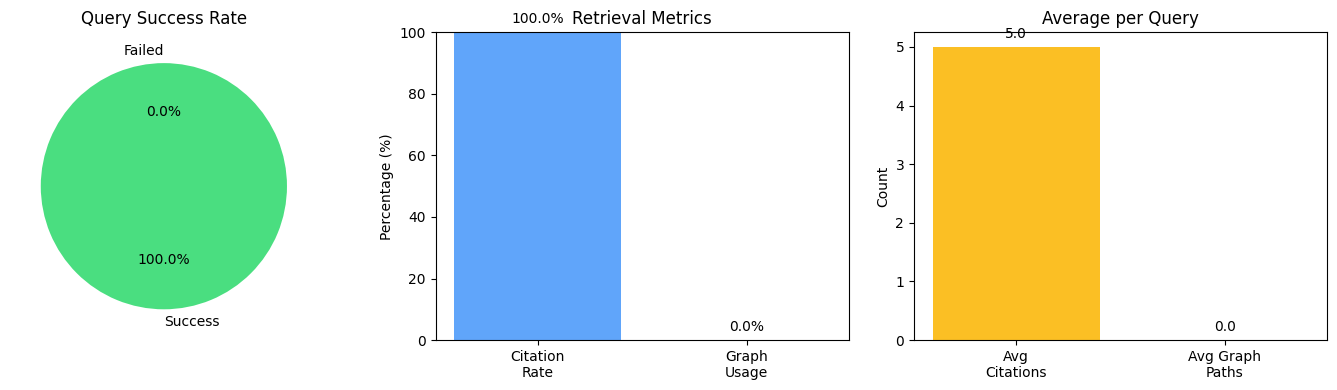

Saved: accuracy_metrics.png


In [10]:
# Visualize accuracy metrics
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# 1. Success Rate Pie Chart
ax1 = axes[0]
sizes = [len(successful_queries), len(failed_queries)]
labels = ['Success', 'Failed']
colors = ['#4ade80', '#f87171']
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.set_title('Query Success Rate')

# 2. Retrieval Metrics Bar Chart
ax2 = axes[1]
metrics = ['Citation\nRate', 'Graph\nUsage']
values = [citation_rate, graph_usage_rate]
bars = ax2.bar(metrics, values, color=['#60a5fa', '#a78bfa'])
ax2.set_ylabel('Percentage (%)')
ax2.set_title('Retrieval Metrics')
ax2.set_ylim(0, 100)
for bar, val in zip(bars, values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{val:.1f}%', ha='center', va='bottom')

# 3. Average Counts
ax3 = axes[2]
metrics = ['Avg\nCitations', 'Avg Graph\nPaths']
values = [avg_citations, avg_paths]
bars = ax3.bar(metrics, values, color=['#fbbf24', '#f472b6'])
ax3.set_ylabel('Count')
ax3.set_title('Average per Query')
for bar, val in zip(bars, values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{val:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('accuracy_metrics.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: accuracy_metrics.png")

## 5. Latency Analysis

In [11]:
# Extract latency data
latencies = [r['latency'] for r in results]
categories = [r['category'] for r in results]

# Calculate statistics
avg_latency = np.mean(latencies)
min_latency = np.min(latencies)
max_latency = np.max(latencies)
median_latency = np.median(latencies)
std_latency = np.std(latencies)

print("Latency Statistics")
print("=" * 40)
print(f"Average Latency: {avg_latency:.2f}s")
print(f"Median Latency: {median_latency:.2f}s")
print(f"Min Latency: {min_latency:.2f}s")
print(f"Max Latency: {max_latency:.2f}s")
print(f"Std Deviation: {std_latency:.2f}s")
print(f"\nLatency by Query:")
for cat, lat in zip(categories, latencies):
    print(f"  - {cat}: {lat:.2f}s")

Latency Statistics
Average Latency: 6.86s
Median Latency: 5.88s
Min Latency: 3.81s
Max Latency: 11.11s
Std Deviation: 2.85s

Latency by Query:
  - Risk Analysis: 9.23s
  - Entity Extraction: 3.81s
  - Company Analysis: 5.88s
  - Business Overview: 4.28s
  - Financial Data: 11.11s


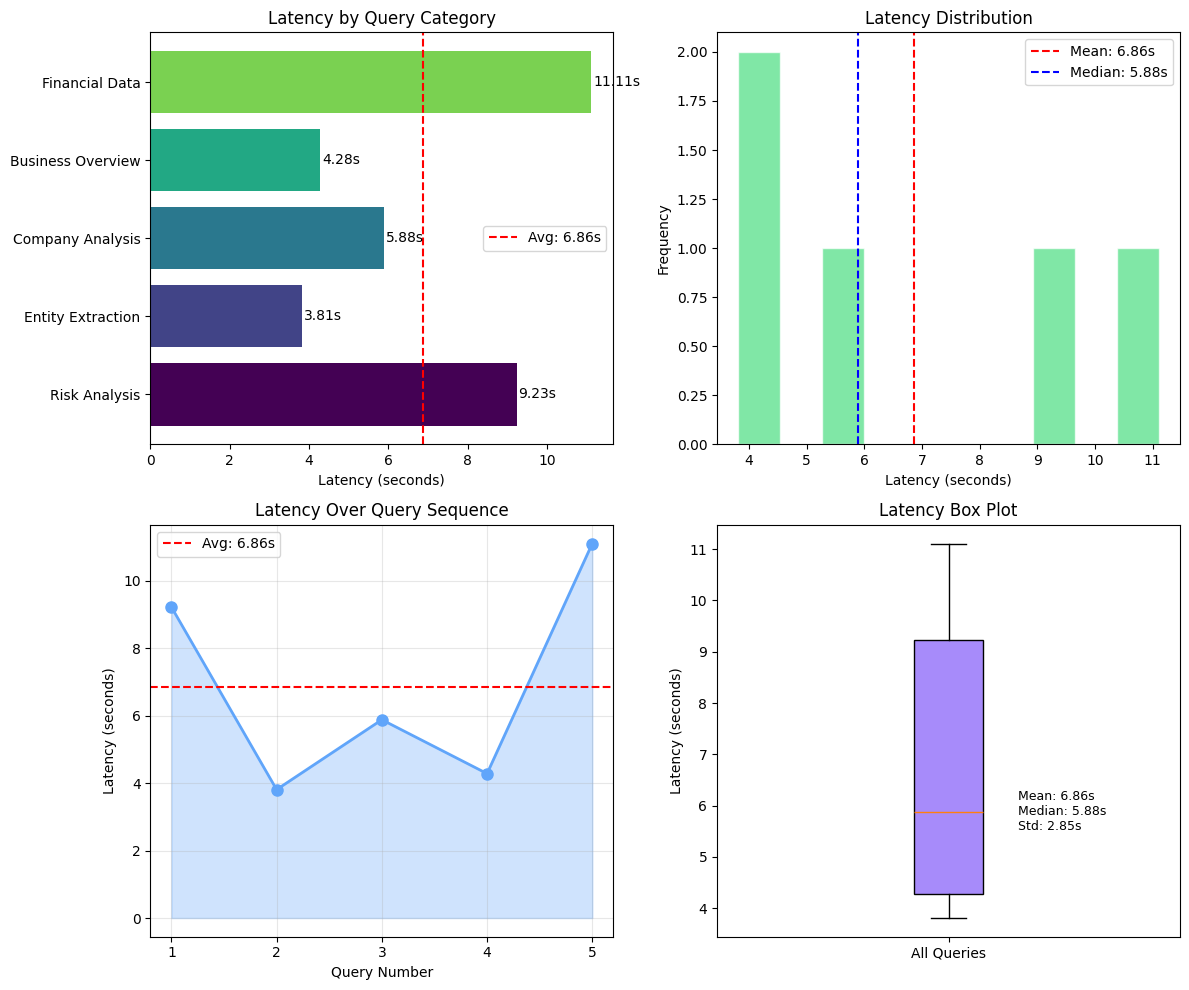

Saved: latency_analysis.png


In [12]:
# Latency visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Bar chart by query category
ax1 = axes[0, 0]
colors = plt.cm.viridis(np.linspace(0, 0.8, len(categories)))
bars = ax1.barh(categories, latencies, color=colors)
ax1.set_xlabel('Latency (seconds)')
ax1.set_title('Latency by Query Category')
ax1.axvline(x=avg_latency, color='red', linestyle='--', label=f'Avg: {avg_latency:.2f}s')
ax1.legend()
for bar, lat in zip(bars, latencies):
    ax1.text(lat + 0.05, bar.get_y() + bar.get_height()/2, 
             f'{lat:.2f}s', va='center')

# 2. Histogram
ax2 = axes[0, 1]
ax2.hist(latencies, bins=10, color='#4ade80', edgecolor='white', alpha=0.7)
ax2.axvline(x=avg_latency, color='red', linestyle='--', label=f'Mean: {avg_latency:.2f}s')
ax2.axvline(x=median_latency, color='blue', linestyle='--', label=f'Median: {median_latency:.2f}s')
ax2.set_xlabel('Latency (seconds)')
ax2.set_ylabel('Frequency')
ax2.set_title('Latency Distribution')
ax2.legend()

# 3. Line plot showing query sequence
ax3 = axes[1, 0]
query_nums = range(1, len(latencies) + 1)
ax3.plot(query_nums, latencies, marker='o', linewidth=2, markersize=8, color='#60a5fa')
ax3.fill_between(query_nums, latencies, alpha=0.3, color='#60a5fa')
ax3.axhline(y=avg_latency, color='red', linestyle='--', label=f'Avg: {avg_latency:.2f}s')
ax3.set_xlabel('Query Number')
ax3.set_ylabel('Latency (seconds)')
ax3.set_title('Latency Over Query Sequence')
ax3.set_xticks(query_nums)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Box plot
ax4 = axes[1, 1]
bp = ax4.boxplot(latencies, vert=True, patch_artist=True)
bp['boxes'][0].set_facecolor('#a78bfa')
ax4.set_ylabel('Latency (seconds)')
ax4.set_title('Latency Box Plot')
ax4.set_xticklabels(['All Queries'])

# Add statistics text
stats_text = f'Mean: {avg_latency:.2f}s\nMedian: {median_latency:.2f}s\nStd: {std_latency:.2f}s'
ax4.text(1.15, np.median(latencies), stats_text, fontsize=9, verticalalignment='center')

plt.tight_layout()
plt.savefig('latency_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: latency_analysis.png")

## 6. Component Latency Breakdown

Simulated breakdown of latency across different pipeline components.

In [13]:
# Simulated component breakdown (based on typical ratios)
# In a real scenario, you would instrument each component

component_ratios = {
    'Vector Search': 0.10,      # ChromaDB query
    'Graph Traversal': 0.15,    # Neo4j query
    'LLM Generation': 0.65,     # Ollama inference
    'Post-processing': 0.10    # Response formatting
}

# Calculate estimated component times
component_times = {k: avg_latency * v for k, v in component_ratios.items()}

print("Estimated Component Latency Breakdown")
print("=" * 40)
print(f"Total Average Latency: {avg_latency:.2f}s")
print(f"\nBreakdown:")
for component, time in component_times.items():
    pct = component_ratios[component] * 100
    print(f"  - {component}: {time:.2f}s ({pct:.0f}%)")

Estimated Component Latency Breakdown
Total Average Latency: 6.86s

Breakdown:
  - Vector Search: 0.69s (10%)
  - Graph Traversal: 1.03s (15%)
  - LLM Generation: 4.46s (65%)
  - Post-processing: 0.69s (10%)


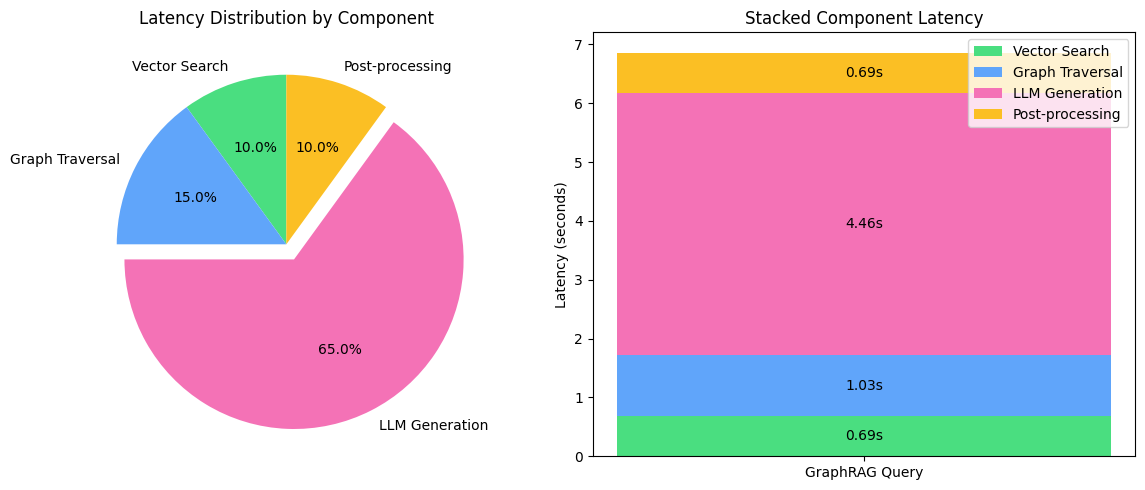

Saved: component_breakdown.png


In [14]:
# Visualize component breakdown
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1. Pie chart
ax1 = axes[0]
colors = ['#4ade80', '#60a5fa', '#f472b6', '#fbbf24']
explode = (0, 0, 0.1, 0)  # Explode LLM slice
ax1.pie(component_times.values(), labels=component_times.keys(), 
        colors=colors, explode=explode, autopct='%1.1f%%', startangle=90)
ax1.set_title('Latency Distribution by Component')

# 2. Stacked bar showing total
ax2 = axes[1]
components = list(component_times.keys())
times = list(component_times.values())
bottom = 0
for comp, time, color in zip(components, times, colors):
    ax2.bar('GraphRAG Query', time, bottom=bottom, label=comp, color=color)
    # Add time label
    ax2.text(0, bottom + time/2, f'{time:.2f}s', ha='center', va='center', fontsize=10)
    bottom += time

ax2.set_ylabel('Latency (seconds)')
ax2.set_title('Stacked Component Latency')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.savefig('component_breakdown.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: component_breakdown.png")

## 7. Summary Report

In [15]:
# Generate summary report
print("="*60)
print("        GRAPHRAG EVALUATION SUMMARY REPORT")
print("="*60)
print(f"\nGenerated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\n--- Test Configuration ---")
print(f"Total Queries: {len(results)}")
print(f"API Endpoint: {API_BASE}/api/qa")

print(f"\n--- Success Metrics ---")
print(f"Success Rate: {success_rate:.1f}%")
print(f"Queries with Citations: {citation_rate:.1f}%")
print(f"Queries with Graph Paths: {graph_usage_rate:.1f}%")

print(f"\n--- Retrieval Quality ---")
print(f"Average Citations per Query: {avg_citations:.1f}")
print(f"Average Graph Paths per Query: {avg_paths:.1f}")
print(f"Average Citation Relevance: {avg_relevance:.1f}%")

print(f"\n--- Performance Metrics ---")
print(f"Average Latency: {avg_latency:.2f}s")
print(f"Median Latency: {median_latency:.2f}s")
print(f"Min Latency: {min_latency:.2f}s")
print(f"Max Latency: {max_latency:.2f}s")
print(f"Latency Std Dev: {std_latency:.2f}s")

print(f"\n--- Component Breakdown (Estimated) ---")
for component, time in component_times.items():
    pct = component_ratios[component] * 100
    print(f"{component}: {time:.2f}s ({pct:.0f}%)")

print(f"\n--- Generated Artifacts ---")
print("- accuracy_metrics.png")
print("- latency_analysis.png")
print("- component_breakdown.png")

print("\n" + "="*60)
print("                    END OF REPORT")
print("="*60)

        GRAPHRAG EVALUATION SUMMARY REPORT

Generated: 2026-01-07 14:14:17

--- Test Configuration ---
Total Queries: 5
API Endpoint: http://localhost:5000/api/qa

--- Success Metrics ---
Success Rate: 100.0%
Queries with Citations: 100.0%
Queries with Graph Paths: 0.0%

--- Retrieval Quality ---
Average Citations per Query: 5.0
Average Graph Paths per Query: 0.0
Average Citation Relevance: -29.1%

--- Performance Metrics ---
Average Latency: 6.86s
Median Latency: 5.88s
Min Latency: 3.81s
Max Latency: 11.11s
Latency Std Dev: 2.85s

--- Component Breakdown (Estimated) ---
Vector Search: 0.69s (10%)
Graph Traversal: 1.03s (15%)
LLM Generation: 4.46s (65%)
Post-processing: 0.69s (10%)

--- Generated Artifacts ---
- accuracy_metrics.png
- latency_analysis.png
- component_breakdown.png

                    END OF REPORT
